# Step 0: Importing necessary libraries

In [2]:
import os
import numpy as np
import skimage as ski
from skimage.color import rgb2gray
from skimage import filters
from skimage.feature import hog
from skimage import exposure

from PIL import Image
import xml.etree.ElementTree as ET
import matplotlib.pyplot as plt
from pathlib import Path
from sklearn.metrics import pairwise
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

# Step 1: Load the Images and Annotation Files

In [3]:
classes = ['n02108915-French_bulldog', 'n02085620-Chihuahua', 'n02091134-whippet', 'n02089078-black-and-tan_coonhound']
annotations = []
dog_images = []
for class_name in classes:
    annotation_dir = os.path.join(os.getcwd(), 'annotation', class_name)
    image_dir = os.path.join(os.getcwd(), 'images', class_name)
    annotations.extend([os.path.join(annotation_dir, f) for f in os.listdir(os.path.join(os.getcwd(), 'annotation', class_name))])
    dog_images.extend([os.path.join(image_dir, f) for f in os.listdir(os.path.join(os.getcwd(), 'images', class_name))])

print(dog_images[0], annotations[0])

E:\loki\DM_1\images\n02108915-French_bulldog\n02108915_10204.jpg E:\loki\DM_1\annotation\n02108915-French_bulldog\n02108915_10204


# Step 2

## Step 2a: Cropping and Resize Images in 4-class Images Dataset

In [4]:
def get_bounding_boxes(annot):
    xml = annot
    tree = ET.parse(xml)
    root = tree.getroot()
    objects = root.findall('object')
    bbox = []
    for o in objects:
        bndbox = o.find('bndbox')
        xmin = int(bndbox.find('xmin').text)
        ymin = int(bndbox.find('ymin').text)
        xmax = int(bndbox.find('xmax').text)
        ymax = int(bndbox.find('ymax').text)
        bbox.append((xmin,ymin,xmax,ymax))
    return bbox

for i in range(len(dog_images)):
    bbox = get_bounding_boxes(annotations[i])
    dog = dog_images[i]
    im = Image.open(dog)
    for j in range(len(bbox)):
        im2 = im.crop(bbox[j])
        im2 = im2.resize((128,128), Image.LANCZOS)
        new_path = dog.replace('images','Cropped')
        new_path = new_path.replace('.jpg','-' + str(j) + '.jpg')
        im2=im2.convert('RGB')
        head, tail = os.path.split(new_path)
        Path(head).mkdir(parents=True, exist_ok=True)
        im2.save(new_path)


## Step 2b: Feature Extraction: Edge histogram AND Similarity Measurements

In [5]:
# i. Choose 1 image from each class

images = [os.path.join(os.getcwd(), 'Cropped', class_name, os.listdir(os.path.join(os.getcwd(), 'Cropped', class_name))[0]) for class_name in classes]

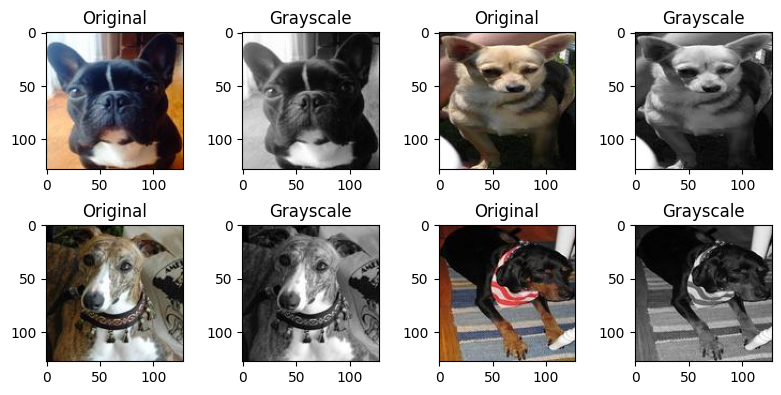

In [6]:
# ii. Converting the color images to grayscale images  
originals = [Image.open(image) for image in images]
grayscale = [rgb2gray(original) for original in originals]

fig, axes = plt.subplots(2, 4, figsize=(8, 4))
ax = axes.ravel()

j=0
for i in range(0, len(ax), 2):
    ax[i].imshow(originals[j])
    ax[i].set_title("Original")
    ax[i+1].imshow(grayscale[j], cmap=plt.cm.gray)
    ax[i+1].set_title("Grayscale")
    j += 1

fig.tight_layout()
plt.show()

In [7]:
# iii. Obtaining the angle each image I

def angle(dx, dy):
    """Calculate the angles between horizontal and vertical operators."""
    return np.mod(np.arctan2(dy, dx), np.pi)

angle_sobels = []
for I in grayscale:
    angle_sobel = angle(filters.sobel_h(I), filters.sobel_v(I))
    angle_sobels.append(angle_sobel)

In [8]:
# iv. Obtaining histogram with 36 bins

hist_1, bin_centers_1 = ski.exposure.histogram(angle_sobels[0], nbins=36)
hist_2, bin_centers_2 = ski.exposure.histogram(angle_sobels[1], nbins=36)
hist_3, bin_centers_3 = ski.exposure.histogram(angle_sobels[2], nbins=36)
hist_4, bin_centers_4 = ski.exposure.histogram(angle_sobels[3], nbins=36)

In [9]:
hist_1, bin_centers_1

(array([467, 427, 462, 416, 441, 427, 369, 382, 386, 430, 401, 447, 462,
        478, 544, 524, 569, 672, 881, 539, 549, 531, 443, 469, 450, 374,
        371, 381, 341, 365, 383, 379, 364, 366, 453, 441]),
 array([0.04363257, 0.13089772, 0.21816286, 0.305428  , 0.39269315,
        0.47995829, 0.56722343, 0.65448858, 0.74175372, 0.82901886,
        0.91628401, 1.00354915, 1.09081429, 1.17807944, 1.26534458,
        1.35260972, 1.43987487, 1.52714001, 1.61440515, 1.7016703 ,
        1.78893544, 1.87620058, 1.96346573, 2.05073087, 2.13799601,
        2.22526116, 2.3125263 , 2.39979144, 2.48705659, 2.57432173,
        2.66158687, 2.74885202, 2.83611716, 2.92338231, 3.01064745,
        3.09791259]))

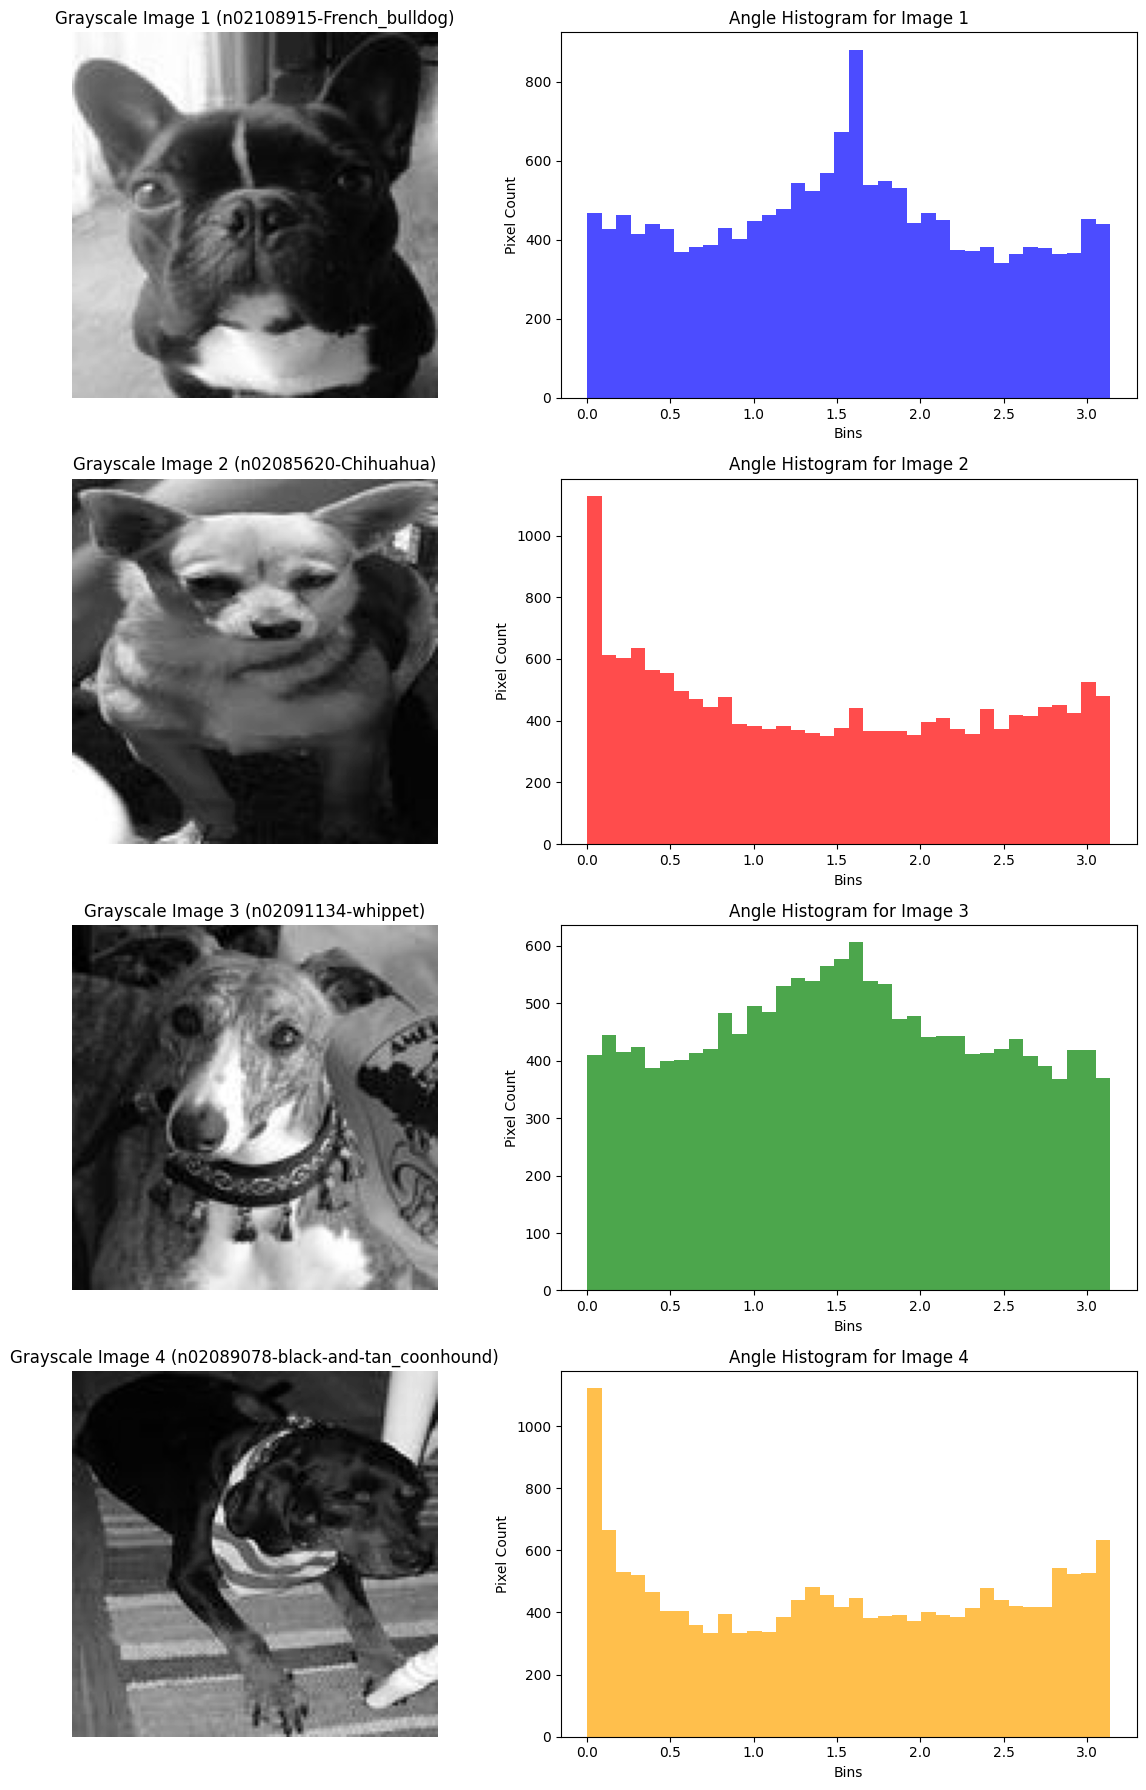

In [10]:
# v. Plotting

fig, axs = plt.subplots(4, 2, figsize=(12, 18))

# Image 1 and its angle histogram
axs[0, 0].imshow(grayscale[0], cmap='gray')
axs[0, 0].set_title(f'Grayscale Image 1 ({classes[0]})')
axs[0, 0].axis('off')

axs[0, 1].bar(bin_centers_1, hist_1, width=bin_centers_1[1] - bin_centers_1[0], color='blue', alpha=0.7)
axs[0, 1].set_title('Angle Histogram for Image 1')
axs[0, 1].set_xlabel('Bins')
axs[0, 1].set_ylabel('Pixel Count')

# Image 2 and its angle histogram
axs[1, 0].imshow(grayscale[1], cmap='gray')
axs[1, 0].set_title(f'Grayscale Image 2 ({classes[1]})')
axs[1, 0].axis('off')

axs[1, 1].bar(bin_centers_2, hist_2, width=bin_centers_2[1] - bin_centers_2[0], color='red', alpha=0.7)
axs[1, 1].set_title('Angle Histogram for Image 2')
axs[1, 1].set_xlabel('Bins')
axs[1, 1].set_ylabel('Pixel Count')

# Image 3 and its angle histogram
axs[2, 0].imshow(grayscale[2], cmap='gray')
axs[2, 0].set_title(f'Grayscale Image 3 ({classes[2]})')
axs[2, 0].axis('off')

axs[2, 1].bar(bin_centers_3, hist_3, width=bin_centers_3[1] - bin_centers_3[0], color='green', alpha=0.7)
axs[2, 1].set_title('Angle Histogram for Image 3')
axs[2, 1].set_xlabel('Bins')
axs[2, 1].set_ylabel('Pixel Count')

# Image 4 and its angle histogram
axs[3, 0].imshow(grayscale[3], cmap='gray')
axs[3, 0].set_title(f'Grayscale Image 4 ({classes[3]})')
axs[3, 0].axis('off')

axs[3, 1].bar(bin_centers_4, hist_4, width=bin_centers_4[1] - bin_centers_4[0], color='orange', alpha=0.7)
axs[3, 1].set_title('Angle Histogram for Image 4')
axs[3, 1].set_xlabel('Bins')
axs[3, 1].set_ylabel('Pixel Count')

plt.tight_layout()
plt.show()

In [11]:
# vi. Distance Calculation

hist_1 = hist_1 / hist_1.sum()
hist_2 = hist_2 / hist_2.sum()

euclidean_distance = pairwise.euclidean_distances([hist_1], [hist_2])[0][0]
manhattan_distance = pairwise.manhattan_distances([hist_1], [hist_2])[0][0]
cosine_distance = pairwise.cosine_distances([hist_1], [hist_2])[0][0]

print("Euclidean Distance:", euclidean_distance)
print("Manhattan Distance:", manhattan_distance)
print("Cosine Distance:", cosine_distance)

Euclidean Distance: 0.06526282369726627
Manhattan Distance: 0.278564453125
Cosine Distance: 0.07143397540530128


## Step 2c: Histogram of Oriented Gradient (HOG) feature descriptor

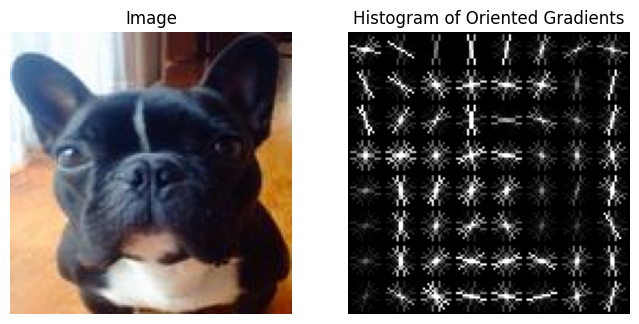

In [12]:
image = originals[0]

fd, hog_image = hog(
    image,
    orientations=8,
    pixels_per_cell=(16, 16),
    cells_per_block=(1, 1),
    visualize=True,
    channel_axis=-1,
)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(8, 4), sharex=True, sharey=True)

ax1.axis('off')
ax1.imshow(image, cmap=plt.cm.gray)
ax1.set_title('Image')

# Rescale histogram for better display
hog_image_rescaled = exposure.rescale_intensity(hog_image, in_range=(0, 10))

ax2.axis('off')
ax2.imshow(hog_image_rescaled, cmap=plt.cm.gray)
ax2.set_title('Histogram of Oriented Gradients')
plt.show()

## Step 2d: Dimensionality reduction (using Principal Component Analysis, PCA)

In [13]:
# i. Using images from all four classes

class_wise_images = {}
parent_folder = os.path.join(os.getcwd(), 'Cropped')
for class_name in classes:
    class_folder = os.path.join(parent_folder, class_name)
    class_wise_images[class_name] = [os.path.join(class_folder, image_file_name) for image_file_name in os.listdir(class_folder)]

In [14]:
# ii. Edge Histograms

histograms = []
labels = []
for class_name in classes:
    for img in class_wise_images[class_name]:
        I = rgb2gray(Image.open(img))
        angle_sobel = angle(filters.sobel_h(I), filters.sobel_v(I))
        hist, bin_centers = ski.exposure.histogram(angle_sobel, nbins=36)
        histograms.append(hist)
        labels.append(class_name)

histograms = np.array(histograms)


In [15]:
# iii. Applying PCA to reduce 36 to 2 dimensions

scaler = StandardScaler()
histograms_scaled = scaler.fit_transform(histograms)

pca = PCA(n_components=2)
histograms_pca = pca.fit_transform(histograms_scaled)

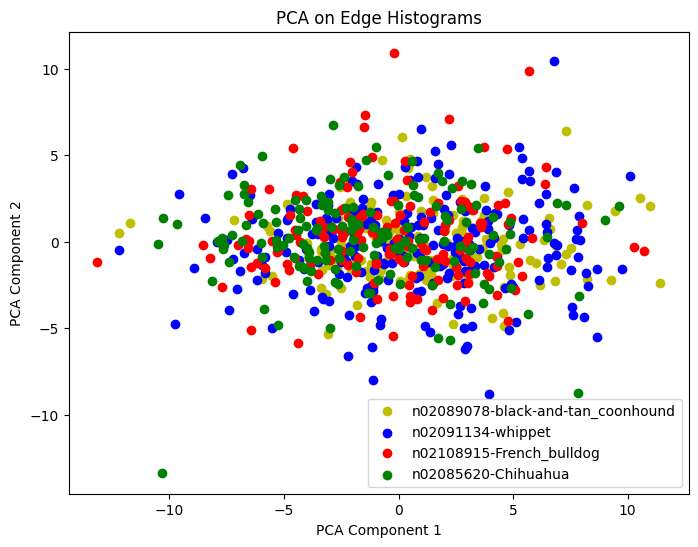

In [16]:
# iv. Plotting the 2D points using four different colors for data from the four classes

colors = dict(zip(classes, ['r', 'g', 'b', 'y']))
plt.figure(figsize=(8, 6))

for label in set(labels):
    indices = np.where(np.array(labels) == label)
    plt.scatter(histograms_pca[indices, 0], histograms_pca[indices, 1], c=colors[label], label=label)

plt.xlabel("PCA Component 1")
plt.ylabel("PCA Component 2")
plt.title("PCA on Edge Histograms")
plt.legend()
plt.show()

#### Q. How many classes are visually separable (i.e., non-overlapping) ?

Ans: None of the classes are visually separable.

# 3. Text processing steps on a tweet (i.e., text) dataset

In [18]:
import pandas as pd
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

In [19]:
train_data = pd.read_json('train.json')

In [20]:
train_data.head(10)

,ID,Tweet,anger,anticipation,disgust,fear,joy,love,optimism,pessimism,sadness,surprise,trust
0,2017-En-10588,"@Daniel_Sankey @hayleyp79 Haha.... Actually, a...",False,False,False,False,True,False,True,False,False,False,False
1,2017-En-40864,Whenever I'm feeling sad I will listen to mons...,False,False,False,False,True,False,False,True,True,False,False
2,2017-En-20790,@Cory_Bonini AP didn't have a productive week ...,True,False,True,True,False,False,False,False,False,False,False
3,2017-En-10816,I should really study today for chemistry but ...,False,True,False,True,True,False,False,False,False,True,False
4,2017-En-30660,Question for all the cheerleaders who ages out...,False,True,False,False,True,False,False,False,False,False,False
5,2017-En-20420,@LonelyGoomba UK cops have an issue fearing in...,False,True,False,True,False,False,False,False,False,False,False
6,2017-En-31163,Class is canceled due to a funeral. Not sure i...,False,False,False,False,True,False,False,False,True,False,False
7,2017-En-20601,Research has determined 70% of #laughter is ac...,False,False,False,True,False,False,False,False,False,False,False
8,2017-En-20327,Overtime... #TeamNA #WCH2016 #nervous,False,False,False,True,False,False,False,True,False,False,False
9,2017-En-40692,God's love spring.Of one dat sunk his whole es...,False,False,False,False,True,True,True,False,False,False,False


In [21]:
train_data.columns

Index(['ID', 'Tweet', 'anger', 'anticipation', 'disgust', 'fear', 'joy',
       'love', 'optimism', 'pessimism', 'sadness', 'surprise', 'trust'],
      dtype='object')

In [24]:
tweets = train_data.Tweet

In [25]:
count_vectorizer = CountVectorizer()
count_matrix = count_vectorizer.fit_transform(tweets)

tfidf_vectorizer = TfidfVectorizer()
tfidf_matrix = tfidf_vectorizer.fit_transform(tweets)

count_dimensionality = count_matrix.shape
tfidf_dimensionality = tfidf_matrix.shape

print(f"CountVectorizer dimensionality: {count_dimensionality}")
print(f"TfidfVectorizer dimensionality: {tfidf_dimensionality}")

CountVectorizer dimensionality: (3000, 9608)
TfidfVectorizer dimensionality: (3000, 9608)


In [26]:
classes = ['anger', 'love', 'sadness', 'surprise']

In [27]:
pca = PCA(n_components=2)
count_vec_pca = pca.fit_transform(count_matrix.toarray())  

pca = PCA(n_components=2)
tfidf_vec_pca = pca.fit_transform(tfidf_matrix.toarray())  

In [28]:
count_vec_pca, tfidf_vec_pca

(array([[ 0.24862774, -0.59759913],
        [-0.2484826 ,  0.83591882],
        [-0.36694558, -0.13816501],
        ...,
        [ 0.22717505, -0.64319115],
        [ 0.62190282, -0.38515722],
        [-0.69583558, -0.40309284]]),
 array([[ 0.00735087, -0.05598275],
        [-0.01628727, -0.01314447],
        [ 0.01123442, -0.04260868],
        ...,
        [ 0.00050471, -0.05735108],
        [-0.03429677, -0.06019278],
        [ 0.02155948, -0.03185109]]))

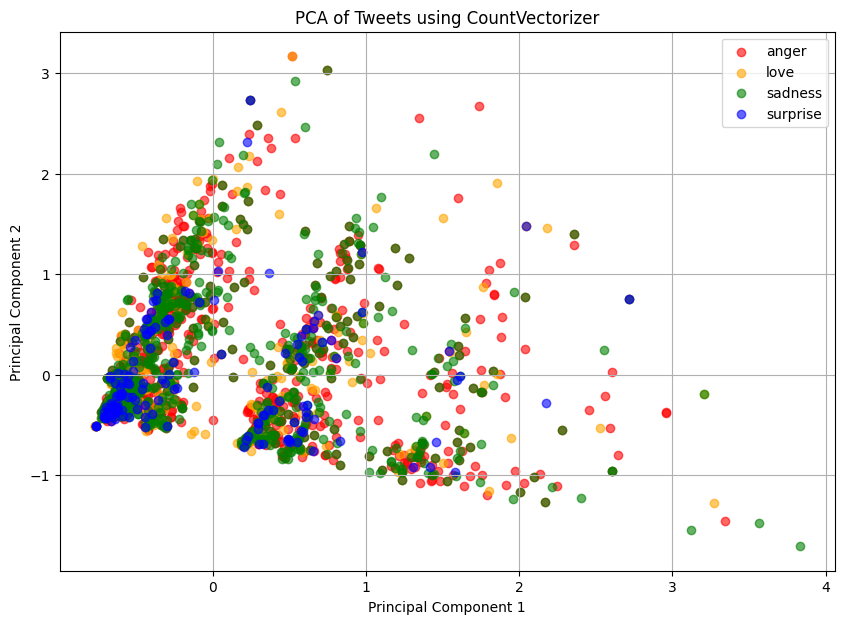

In [31]:
pca_df = pd.DataFrame(data=count_vec_pca, columns=['PC1', 'PC2'])

# Prepare color mapping for the classes
colors = {
    'anger': 'red',
    'love': 'orange',
    'sadness': 'green',
    'surprise': 'blue'
}

# Create a figure for plotting
plt.figure(figsize=(10, 7))

# Plot PCA results for each class
for label, color in colors.items():
    # Find indices where the label is True
    indices = train_data.index[train_data[label]].tolist()
    # Scatter plot only those points belonging to the current label
    plt.scatter(pca_df.loc[indices, 'PC1'],
                pca_df.loc[indices, 'PC2'],
                label=label,
                color=color,
                alpha=0.6)

# Adding titles and labels
plt.title('PCA of Tweets using CountVectorizer')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.legend()
plt.grid()
plt.show()

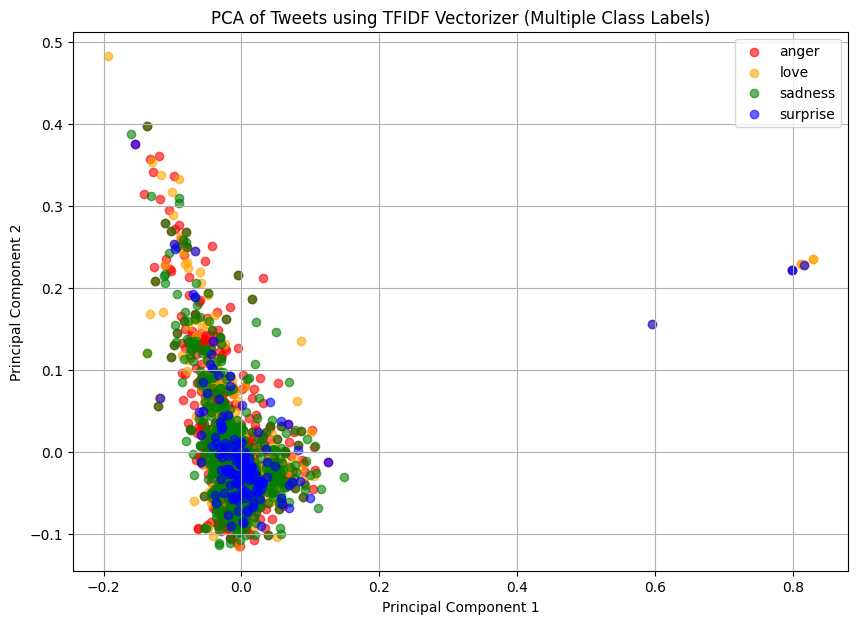

In [84]:
pca_df = pd.DataFrame(data=tfidf_vec_pca, columns=['PC1', 'PC2'])

# Prepare color mapping for the classes
colors = {
    'anger': 'red',
    'love': 'orange',
    'sadness': 'green',
    'surprise': 'blue'
}

# Create a figure for plotting
plt.figure(figsize=(10, 7))

# Plot PCA results for each class
for label, color in colors.items():
    # Find indices where the label is True
    indices = train_data.index[train_data[label]].tolist()
    # Scatter plot only those points belonging to the current label
    plt.scatter(pca_df.loc[indices, 'PC1'],
                pca_df.loc[indices, 'PC2'],
                label=label,
                color=color,
                alpha=0.6)

# Adding titles and labels
plt.title('PCA of Tweets using TFIDF Vectorizer')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.legend()
plt.grid()
plt.show()

Based on the above the plots that were contructed from Count Vectorizer and TFIDF Vectorizer, None of them has visually separable classes, all of them  overlapping.